In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Union, List, Tuple

# Helper funcs

In [34]:
bins = np.linspace(0, 255, 52)


def exists(obj):
    return obj is not None


def print_img_info(img: np.ndarray, desc: str = ""):
    print(
        desc,
        f"min: {img.min()}",
        f"max: {img.max() }",
        f"mean: {img.mean():.2f}",
        f"ndim: {img.ndim}",
        f"channels: {img.shape[-1]}",
    )


def elementwise_mult(
    iterable: Tuple[Union[int, float],...], factor: float
) -> Tuple[Union[int, float],...]:
    return tuple(map(lambda x: x * factor, iterable))


def read_image(image_path: Union[str, Path]) -> np.ndarray:
    """Reads an image from a path and converts it to RGB format."""
    if isinstance(image_path, Path):
        image_path = str(image_path)
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    return image.astype(np.float32)


def read_mask(mask_path: Union[str, Path]) -> np.ndarray:
    """Reads a mask from a path and transform it to binary."""
    if isinstance(mask_path, Path):
        mask_path = str(mask_path)
    mask = cv2.imread(mask_path, 0) / 255.0
    assert_mask_is_binary(mask)
    return mask.astype(np.float32)


def assert_mask_is_binary(mask: np.ndarray):
    """Counts all the pixels different to zero and one to check if binary."""
    assert (
        np.count_nonzero((mask != 0) & (mask != 1)) == 0
    ), f"Mask is not binary. Unique values: {np.unique(mask)}"


def read_images_grid(
    patches_paths: Union[List[str], List[Path]]
) -> List[List[np.ndarray]]:
    patches = []
    for i, patches_paths_row in enumerate(patches_paths):
        images_row = []
        for j, patch_path in enumerate(patches_paths_row):
            image = read_image(patch_path) if exists(patch_path) else np.zeros((1024, 1024, 3))
            images_row.append(image)
        patches.append(images_row)
    return patches


def crop_black_frames_from_image(img: np.ndarray) -> np.ndarray:    
    positions = np.nonzero(img)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()
    return img[top:bottom, left:right]


def sort_paths_from_idxs(
    patches_paths: Union[List[str], List[Path]]
) -> List[List[Union[str, Path]]]:
    """Creates a grid of paths from a list of paths based on their ids."""
    if isinstance(patches_paths[0], str):
        patches_paths = [Path(patch_path) for patch_path in patches_paths]
    idxs = [patch_path.stem.split("_")[-2:] for patch_path in patches_paths]
    idxs = [[int(i[0]), int(i[1])] for i in idxs]

    # Create the grid.
    (y_min, x_min), (y_max, x_max) = np.min(idxs, axis=0), np.max(idxs, axis=0)
    sorted_paths, missing_patches_idxs = [], []
    for j in range(y_max + 1):
        row_paths = []
        for i in range(x_max + 1):
            if [j, i] not in idxs:
                missing_patches_idxs.append([j, i])
                row_paths.append(None)
            else:
                row_paths.append(patches_paths[idxs.index([j, i])])
        sorted_paths.append(row_paths)

    return sorted_paths, missing_patches_idxs


# Figuring it out how to read the images

In [3]:
dset_dir = "/data/histopathology/TCGA/"
dset_dir = Path(dset_dir)

patches_dir = dset_dir / "patches"
masks_dir = dset_dir / "masks"

# In the patches directory are more directories and in the masks directory are png files.
patches_dirs = sorted(patches_dir.iterdir())
masks_paths = sorted(masks_dir.iterdir())

mask_sample_ids = [mask_path.stem[:-5] for mask_path in masks_paths]
patches_sample_ids = [patch_dir.name for patch_dir in patches_dirs]
test_sample_ids = sorted(list(set(patches_sample_ids).difference(mask_sample_ids)))
train_sample_ids = sorted(list(set(patches_sample_ids).intersection(mask_sample_ids)))

print(f"Number of samples with masks: {len(train_sample_ids)} \n")
print(f"Samples ids without masks:", *test_sample_ids, sep="\n- ")

Number of samples with masks: 33 

Samples ids without masks:
- TCGA-99-8028-01Z-00-DX1.23de89b1-67f8-41fb-980a-010ea190d687
- TCGA-99-8032-01Z-00-DX1.7380b78f-ea25-43e0-ac90-194b5c6b1432
- TCGA-J2-8194-01Z-00-DX1.7700924D-B6AF-46A7-A7D7-B5C17A66C5F7
- TCGA-MP-A4TK-01Z-00-DX1.57494698-D9D9-4C04-AAB2-16616CCFDCC9
- TCGA-NJ-A55R-01Z-00-DX1.2E2B3642-4E1C-47DB-AF7B-988D586C0986


Los parches se sacaron a 10x; como la imagen originalmente es 40x, significa que el parche se redujo 4 veces. Sin embargo, las máscaras se redujeron mucho más. En estos momentos no recuerdo cuánto fue, pero debió ser 16 o 32 veces. Si me envía una de las máscaras, le puedo dar el valor exacto (no tengo las máscaras conmigo). Las imágenes y las máscaras deberían cuadrar perfectamente, algo así:

German:

> Listo, ya subí las imágenes. En teoría solo deberían faltar parches que tengan una cantidad muy insignificante de tejido. Si hacen falta más, por favor avísenme.
> Estuve revisando los parches y sugiero que excluyan del análisi la imagen "TCGA-55-8207-01Z-00-DX1 2dafc442-f927-4b0d-b197-cc8c5f86d0fc" pues es muy pequeña y no tiene mucho contenido.
> Finalmente, revisé la máscara de tumor y corresponde a 1/32 del tamaño original.

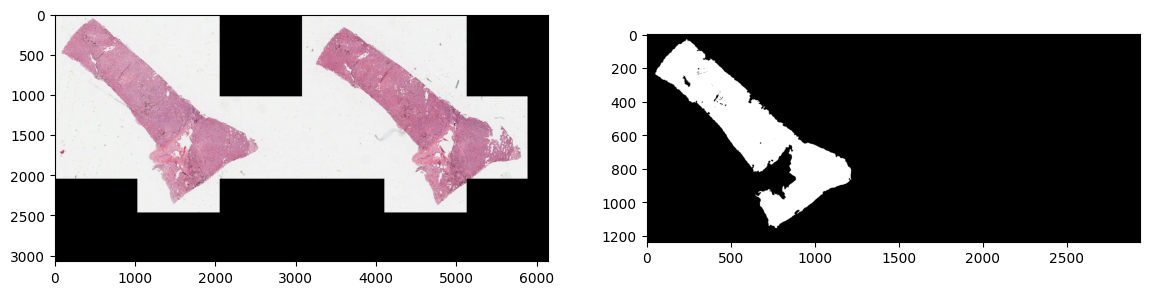

In [ ]:
sample_id = 'TCGA-99-8025-01Z-00-DX1.76d4e012-91a7-4f1d-ba0f-4cecd812ec49'

sample_patches_dir = patches_dir / sample_id
sample_patches_paths = sorted(sample_patches_dir.iterdir())

sorted_sample_patches_paths, missing_patches_idxs = sort_paths_from_idxs(
    sample_patches_paths
)
sorted_sample_patches = read_images_grid(sorted_sample_patches_paths)
reconstructed_sample_image = np.vstack(
    [np.hstack(row) for row in sorted_sample_patches]
).astype(np.float32)
reconstructed_sample_image = reconstructed_sample_image / 255.0

sample_mask_path = masks_dir / f"{sample_id}_mask.png"
sample_mask = read_mask(sample_mask_path)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].imshow(reconstructed_sample_image)
axs[1].imshow(sample_mask, cmap="gray")

# Crop on the the farest zero pixel

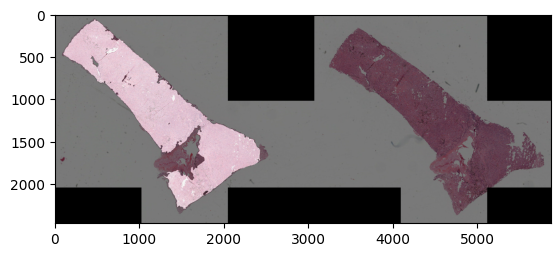

In [30]:
plot_img = crop_black_frames_from_image(reconstructed_sample_image)
height, width = plot_img.shape[:2]
resized_mask = cv2.resize(sample_mask, (width, height))

plt.imshow(plot_img)
plt.imshow(resized_mask, cmap='gray', alpha=0.5)

# References

- Zoom efffect: https://github.com/Jeongchan-Kim/Histology-Image-weakly-supervised-learning-segmentation/blob/main/Histology_Image.ipynb